In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
from sklearn.metrics import mean_squared_error
import time

In [101]:
def logistic_model(t_a, alpha=30.2, beta=15.8, gamma=0.15, mu=0.0):
    """
    This function calculates the stream temperature
    based on a logistic correlation with ambient air 
    temperature from Segura et al. 2014 (doi:10.1002/hyp.10357)
    """
    
    ts = mu + (alpha-mu)/(1+np.exp(gamma*(beta-t_a)))
    
    return ts

In [102]:
to_celcius = lambda T: 5/9*(T-32)

In [103]:
temp_df = pd.read_csv('nrel_psm_data/BrownsFerry_Temperature_2007_2020.csv', index_col='time', parse_dates=True)
temp_df.head()

,Temp_BrownsFerry
time,
2007-01-01 00:00:00,6.0
2007-01-01 00:30:00,5.0
2007-01-01 01:00:00,5.0
2007-01-01 01:30:00,5.0
2007-01-01 02:00:00,5.0


In [106]:
bf = pd.read_csv('cooling_data/brownsferry_cooling.csv', index_col='date', parse_dates=True)

In [107]:
monthly_temp = temp_df[temp_df.index.year > 2011].resample('M').mean()
monthly_temp.head()

,Temp_BrownsFerry
time,
2012-01-31,6.612903
2012-02-29,7.664511
2012-03-31,15.255376
2012-04-30,16.249306
2012-05-31,21.779570


In [108]:
bf['modeled_intake'] = [logistic_model(ta) for ta in monthly_temp['Temp_BrownsFerry'].values]

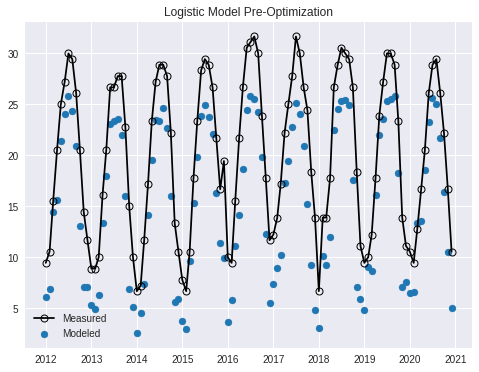

In [110]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bf.index, 
        bf.avg_intake_temp_C, 
        label='Measured', 
        marker='o', 
        color='k', 
        markerfacecolor='none', 
        markeredgewidth=1)
ax.scatter(bf.index, bf.modeled_intake, label='Modeled', marker='o', color='tab:blue')
ax.legend()
ax.set_title('Logistic Model Pre-Optimization')
plt.show()

In [10]:
mean_squared_error(bf.avg_intake_C, bf.modeled_intake, squared=False)

5.148002269784263

## Optimize the Logistic Model

In [11]:
N = 200
alphas = np.linspace(15,45,N)
betas = np.linspace(10,22,N)
gammas = np.linspace(0,5,N)

In [111]:
Y = bf.avg_intake_temp_C.values
X = monthly_temp.Temp_BrownsFerry.values

In [13]:
errors = np.zeros((N,N,N))
errors.shape

(200, 200, 200)

In [14]:
start = round(time.perf_counter(),3)
for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        for k, y in enumerate(gammas):
            Y_pred = logistic_model(X, alpha=a, beta=b, gamma=y)
            rmse = mean_squared_error(Y, Y_pred, squared=False)
            errors[i][j][k] = rmse
    print(f"{((i+1)*N**2/N**3)*100}% complete")
end = round(time.perf_counter(), 3)
print(f"This grid search took {(end-start)/60} minutes")

0.5% complete
1.0% complete
1.5% complete
2.0% complete
2.5% complete
3.0% complete
3.5000000000000004% complete
4.0% complete
4.5% complete
5.0% complete
5.5% complete
6.0% complete
6.5% complete
7.000000000000001% complete
7.5% complete
8.0% complete
8.5% complete
9.0% complete
9.5% complete
10.0% complete
10.5% complete
11.0% complete
11.5% complete
12.0% complete
12.5% complete
13.0% complete
13.5% complete
14.000000000000002% complete
14.499999999999998% complete
15.0% complete
15.5% complete
16.0% complete
16.5% complete
17.0% complete
17.5% complete
18.0% complete
18.5% complete
19.0% complete
19.5% complete
20.0% complete
20.5% complete
21.0% complete
21.5% complete
22.0% complete
22.5% complete
23.0% complete
23.5% complete
24.0% complete
24.5% complete
25.0% complete
25.5% complete
26.0% complete
26.5% complete
27.0% complete
27.500000000000004% complete
28.000000000000004% complete
28.499999999999996% complete
28.999999999999996% complete
29.5% complete
30.0% complete
30.5% 

In [15]:
minLoss = np.min(errors)
index_min = np.where(errors == minLoss)
a_idx = index_min[0][0]
b_idx = index_min[1][0]
y_idx = index_min[2][0]
# print(index_min, a_idx, b_idx, y_idx)
a_min = alphas[a_idx]
b_min = betas[b_idx]
y_min = gammas[y_idx]

In [16]:
bf['modeled_intake'] = [logistic_model(ta, 
                                       alpha=a_min, 
                                       beta=b_min, 
                                       gamma=y_min) for ta in monthly_temp['Temp_BrownsFerry'].values]

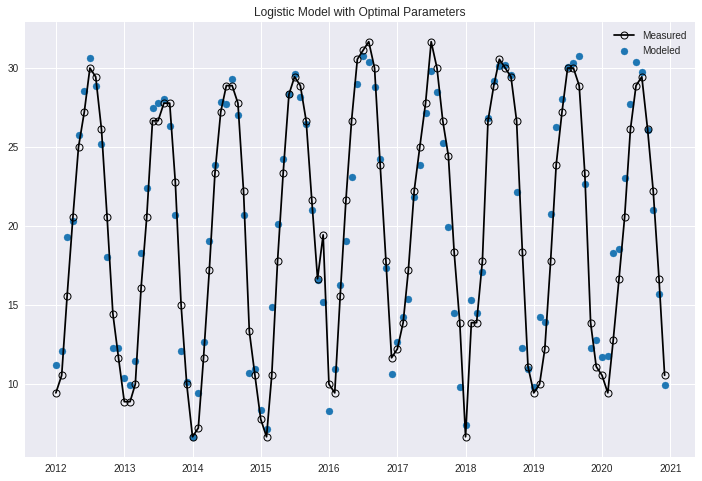

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bf.index, 
        bf.avg_intake_C, 
        label='Measured', 
        marker='o', 
        color='k', 
        markerfacecolor='none', 
        markeredgewidth=1)
ax.scatter(bf.index, bf.modeled_intake, label='Modeled', marker='o', color='tab:blue')
ax.legend()
ax.set_title('Logistic Model with Optimal Parameters')
plt.show()

In [19]:
minLoss

1.8987416386958735

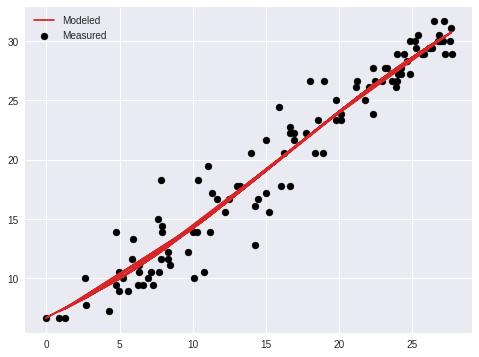

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(monthly_temp.Temp_BrownsFerry, bf.avg_intake_C, label='Measured', marker='o', color='k')
ax.plot(monthly_temp.Temp_BrownsFerry, bf.modeled_intake, label='Modeled', color='tab:red')
ax.legend()
plt.show()

In [33]:
interp_df = bf[['modeled_intake']].copy()

In [42]:
interp_df = interp_df.resample('D').mean().interpolate('polynomial', order=3)

In [43]:
interp_df

,modeled_intake
date,
2012-01-01,11.226080
2012-01-02,10.912216
2012-01-03,10.628757
2012-01-04,10.374916
2012-01-05,10.149909
...,...
2020-11-27,10.790252
2020-11-28,10.581234
2020-11-29,10.370437


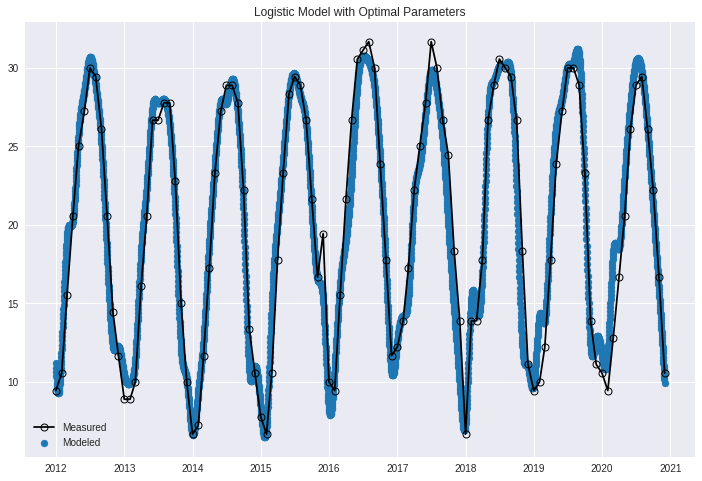

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bf.index, 
        bf.avg_intake_C, 
        label='Measured', 
        marker='o', 
        color='k', 
        markerfacecolor='none', 
        markeredgewidth=1)
ax.scatter(interp_df.index, interp_df.modeled_intake, label='Modeled', marker='o', color='tab:blue')
ax.legend()
ax.set_title('Logistic Model with Optimal Parameters')
plt.show()

<AxesSubplot:xlabel='time'>

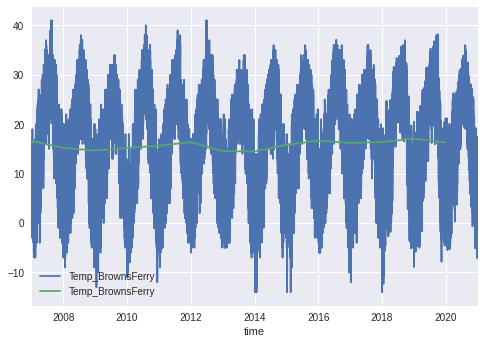

In [46]:
ax = temp_df.plot()
temp_df.resample('Y').mean().plot(ax=ax)

## Calculate the Effluent Temperature

In [61]:
R = 0.79
E_in = 27770727 # MMBTU
E_out = 2658509 # MWh
w_in = 1995069 # gal per min
w_out = 1994661 # gal per min
T_in = 51 # Fahrenheit
C_w = 4.19 # kJ/kg*K
h_w = 2257 # kJ/kg = J/g
# conversions
minutes_per_month = 60*24*31
gal_to_kg = 3.79 # kg/gal
w_inkg = w_in * gal_to_kg
w_outkg = w_out * gal_to_kg
w_inkgMonth = w_inkg*minutes_per_month
w_outkgMonth = w_outkg*minutes_per_month
w_evap = w_inkgMonth-w_outkgMonth
T_inC = to_celcius(T_in) # Celcius
mmbtu_to_mwh = lambda m: m*1e6/3.412e6
E_in_mwh = mmbtu_to_mwh(E_in)  # MWh
mwh_to_kj = lambda e: e*3.6e6
E_in_kj = mwh_to_kj(E_in_mwh)
E_out_kj = mwh_to_kj(E_out)

T_out = ((1-R)*(E_in_kj-E_out_kj) + w_inkgMonth*C_w*(T_inC) - w_evap*h_w)/(w_outkgMonth*C_w)
print(9/5*T_out+32, 'F')

56.08001863318489 F


In [61]:
E_in_kj-E_out_kj

5989998104103.166

In [62]:
w_inkg*C_w*T_inC 

31939036.59075556

In [63]:
w_evap*h_w

100405536

In [64]:
w_outkg*C_w

2887899.98552

In [65]:
T_inC

8.88888888888889

In [91]:
T_out

13.383907528573273

In [73]:
# Quad Cities

R = 0.12

E_out = 688532+693208 # MWh
E_in_U = E_out*1000*8.29e-7*3900e6
E_in = 7201444+7250351 # MMBTU
w_in = 535750 # gal per min
w_out = 535750 # gal per min
T_in = 33 # Fahrenheit
T_out_measured = 77
C_w = 4.181 # kJ/kg*K
h_w = 2256 # kJ/kg = J/g
# conversions
minutes_per_month = 60*24*30
gal_to_kg = 3.79 # kg/gal
w_inkg = w_in * gal_to_kg
w_outkg = w_out * gal_to_kg
w_inkgMonth = w_inkg*minutes_per_month
w_outkgMonth = w_outkg*minutes_per_month
w_evap = w_inkgMonth-w_outkgMonth
# w_evap = 0
T_inC = to_celcius(T_in) # Celcius
mmbtu_to_mwh = lambda m: m*1e6/3.412e6
E_in_mwh = mmbtu_to_mwh(E_in)  # MWh
mwh_to_kj = lambda e: e*3.6e6
E_in_kj = mwh_to_kj(E_in_mwh)
E_out_kj = mwh_to_kj(E_out)

T_out = ((1-R)*(E_in_kj-E_out_kj) + w_inkgMonth*C_w*(T_inC) - w_evap*h_w)/(w_outkgMonth*C_w)
print(9/5*T_out+32)

77.3733092152348


## Check the accuracy of a linear model!

In [112]:
import seaborn as sb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [113]:
print(x.shape, y.shape)

(108,) (108,)


In [114]:
x = monthly_temp['Temp_BrownsFerry'].values
y = bf['avg_intake_temp_C'].values

# I run the linear regression
x2 = sm.add_constant(x) # necessary if we want regression equation to have intercept

mod_uni = sm.OLS(y,x2).fit()
y_pred_uni = mod_uni.fittedvalues

# What if wanted to make predictions using different data for x?
# mod_uni.predict(x2) # make the predictions by the model

In [130]:
temp_short = temp_df[temp_df.index.year > 2011].resample('D').mean()
Xnew = sm.add_constant(temp_short['Temp_BrownsFerry'].values)
ynewpred = mod_uni.predict(Xnew)  # predict out of sample
ynewpred


array([13.84699397,  5.65390884,  2.85152343, ...,  9.68039177,
       15.84369357, 12.61900425])

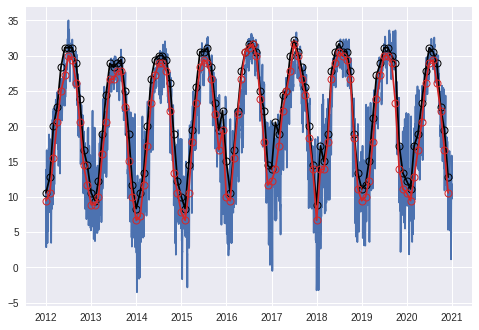

In [131]:
fig, ax = plt.subplots()
ax.plot(temp_short.index, ynewpred)
ax.plot(bf.index, 
        bf.max_intake_temp_C, 
        label='Measured', 
        marker='o', 
        color='k', 
        markerfacecolor='none', 
        markeredgewidth=1)
ax.plot(bf.index, 
        bf.avg_intake_temp_C, 
        label='Measured', 
        marker='o', 
        color='tab:red', 
        markerfacecolor='none', 
        markeredgewidth=1)

In [117]:
print(mod_uni.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     1590.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.22e-65
Time:                        13:41:56   Log-Likelihood:                -224.31
No. Observations:                 108   AIC:                             452.6
Df Residuals:                     106   BIC:                             458.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1868      0.418     12.408      0.0

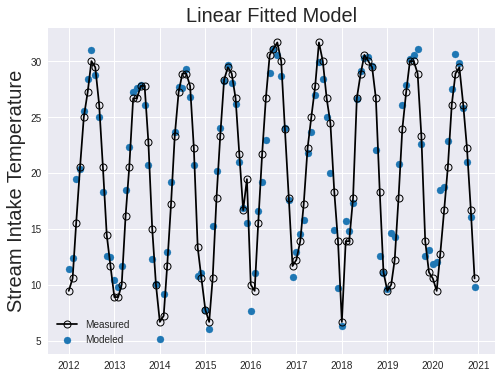

In [165]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bf.index, 
        bf.avg_intake_temp_C, 
        label='Measured', 
        marker='o', 
        color='k', 
        markerfacecolor='none', 
        markeredgewidth=1)
ax.scatter(bf.index, y_pred_uni, label='Modeled', marker='o', color='tab:blue')
ax.legend()
ax.set_ylabel('Stream Intake Temperature', fontsize=20)
ax.set_title('Linear Fitted Model', fontsize=20)
plt.show()

In [120]:
mean_squared_error(y, y_pred_uni, squared=False)

1.9310252625772009

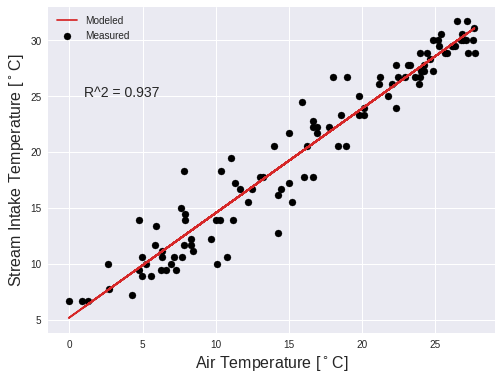

In [162]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(monthly_temp.Temp_BrownsFerry, bf.avg_intake_temp_C, label='Measured', marker='o', color='k')
ax.plot(monthly_temp.Temp_BrownsFerry, y_pred_uni, label='Modeled', color='tab:red')
ax.text(x=1,y=25,s=f'R^2 = 0.937', fontsize=14)
ax.legend()
ax.set_xlabel('Air Temperature [$^\circ$C]', fontsize=16)
ax.set_ylabel('Stream Intake Temperature [$^\circ$C]', fontsize=16)
plt.show()

Text(0.5, 1.0, 'Residuals')

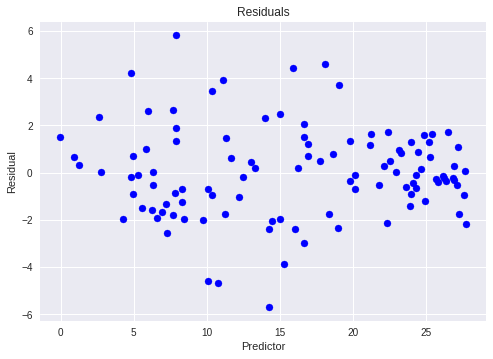

In [122]:
# And here are the residuals from the regression!
fig,ax=plt.subplots()
ax.scatter(x, y-y_pred_uni,color='b')
ax.set_xlabel('Predictor')
ax.set_ylabel('Residual')
ax.set_title('Residuals')

In [123]:
gaussian = lambda sigma, mu, bins: 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) )

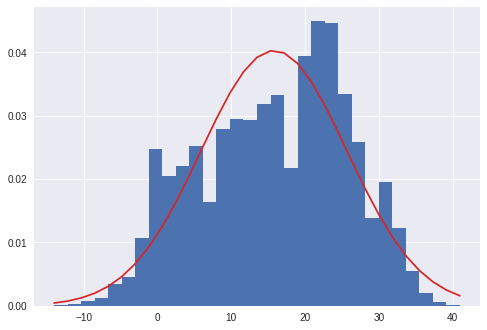

In [124]:
fig, ax = plt.subplots()
sd = 9.903
mean = 15.8
count, bins, ignored = ax.hist(temp_df['Temp_BrownsFerry'], 30, density=True)
norm_temp = gaussian(sd, mean, bins)
ax.plot(bins, norm_temp, color='tab:red')

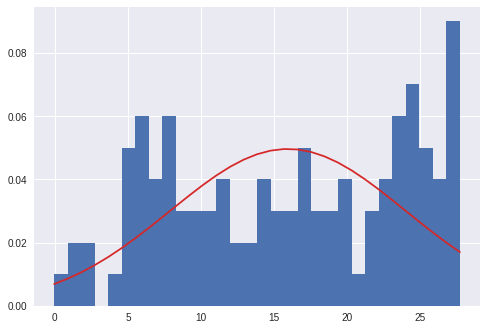

In [166]:
fig, ax = plt.subplots()
sd = 8.04
mean = 15.94
count, bins, ignored = ax.hist(monthly_temp['Temp_BrownsFerry'], 30, density=True)
norm_temp = gaussian(sd, mean, bins)
ax.plot(bins, norm_temp, color='tab:red')

Text(0.5, 0, 'Stream Temperature')

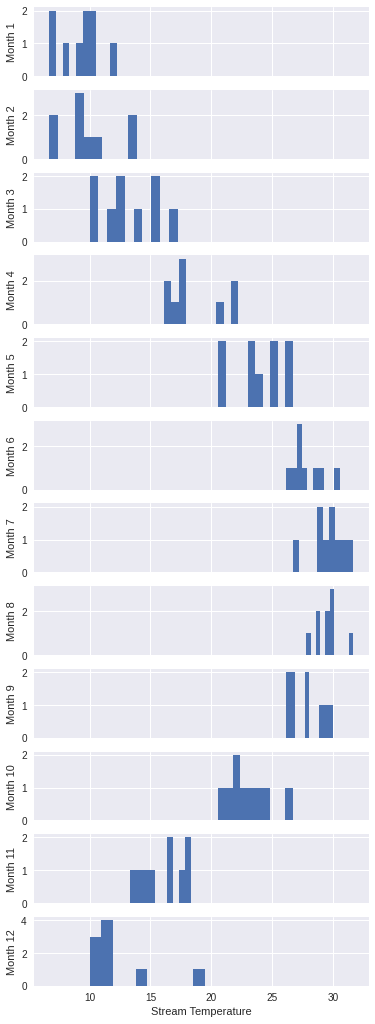

In [168]:
month_groups = bf.groupby(bf.index.month)
fig, axes = plt.subplots(12,1, sharex=True, figsize=(6,18))
for i,g in enumerate(month_groups.groups):
    mon_df = month_groups.get_group(g)
#     summer_mask = (year_df.index.month > 5) & (year_df.index.month < 9)
#     year_df[summer_mask].avg_intake_temp_C.hist(ax=axes[i], density=False)    
    mon_df.avg_intake_temp_C.hist(ax=axes[i], density=False)
    axes[i].set_ylabel(f'Month {g}')
axes[11].set_xlabel('Stream Temperature')

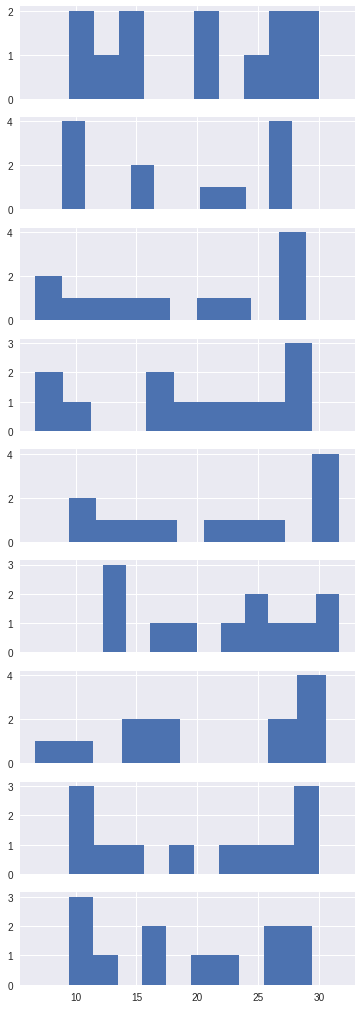

In [141]:
year_groups = bf.groupby(bf.index.year)
fig, axes = plt.subplots(9,1, sharex=True, figsize=(6,18))
for i,g in enumerate(year_groups.groups):
    year_df = year_groups.get_group(g)
    summer_mask = (year_df.index.month > 5) & (year_df.index.month < 9)
#     year_df[summer_mask].avg_intake_temp_C.hist(ax=axes[i], density=False)    
    year_df.avg_intake_temp_C.hist(ax=axes[i], density=False)

In [126]:
monthly_temp.describe()

,Temp_BrownsFerry
count,108.000000
mean,15.945837
std,8.042876
min,-0.048387
25%,8.187114
50%,16.444209
75%,23.923446
max,27.707153


In [127]:
temp_df.describe()

,Temp_BrownsFerry
count,245472.000000
mean,15.800150
std,9.903076
min,-14.000000
25%,8.000000
50%,17.000000
75%,23.200000
max,41.000000


In [128]:
temp_df.groupby(temp_df.index.month).describe()

Temp_BrownsFerry                                                   
                count       mean       std   min   25%   50%   75%   max
time                                                                    
1             20832.0   3.759812  6.452584 -14.0   0.0   3.0   8.0  22.0
2             19008.0   6.165546  6.707523 -14.0   0.0   5.3  11.0  24.7
3             20832.0  10.902275  6.544068  -9.0   6.0  11.0  16.0  27.0
4             20160.0  15.256915  5.862030  -4.0  11.0  16.0  19.7  29.0
5             20832.0  20.267007  5.201259   3.0  17.0  20.0  24.0  33.0
6             20160.0  24.771458  4.265967  11.0  22.0  24.0  28.0  41.0
7             20832.0  26.352155  4.361059  13.0  23.0  26.0  30.0  40.0
8             20832.0  26.258953  4.805634  13.0  23.0  25.8  30.0  41.0
9             20160.0  23.156667  5.618837   6.0  19.0  23.0  27.0  38.0
10            20832.0  16.614915  6.569956  -1.0  12.0  17.0  21.0  38.2
11            20160.0   9.475536  6.417592  -7.8   5.0   9.0  14.0  31.0
12            20832.0   6.082133  6.148529 -12.0   1.0   6.0  10.0  23.0

time
1     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

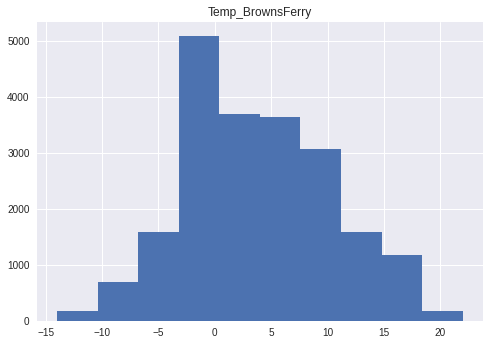

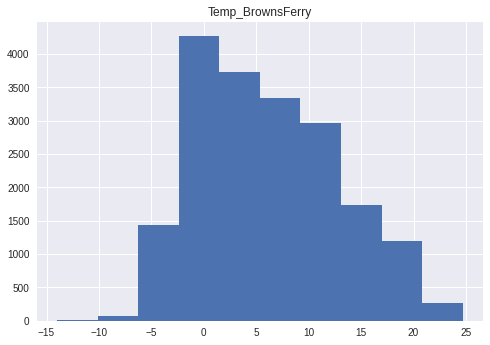

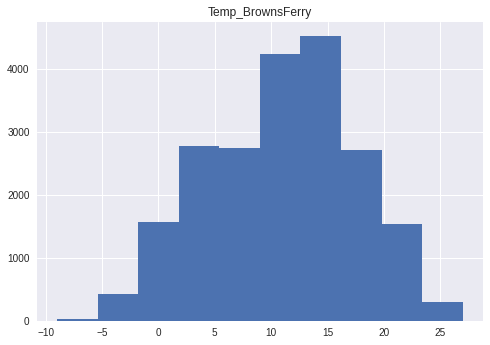

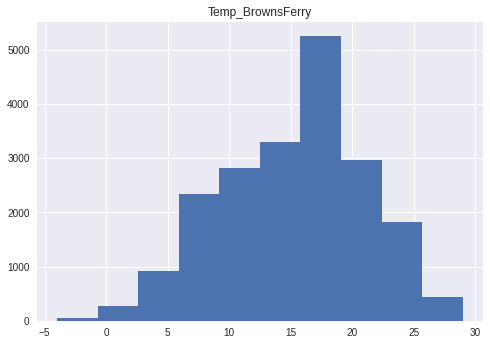

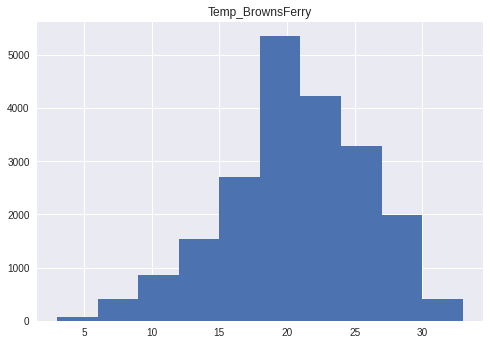

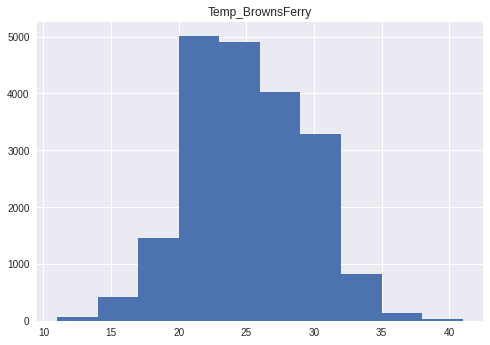

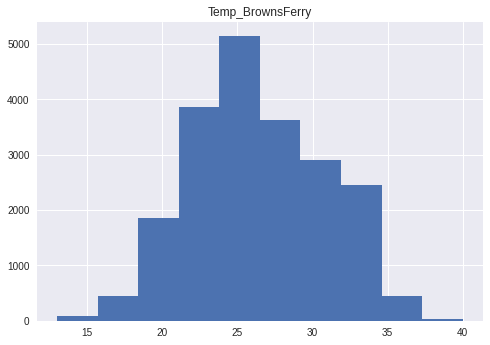

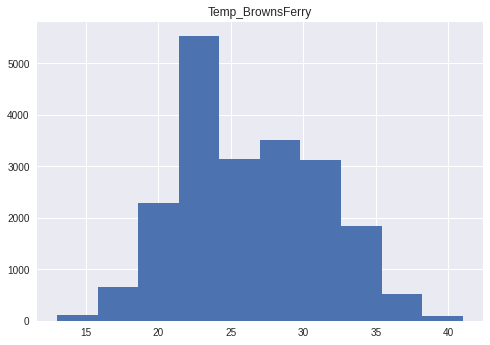

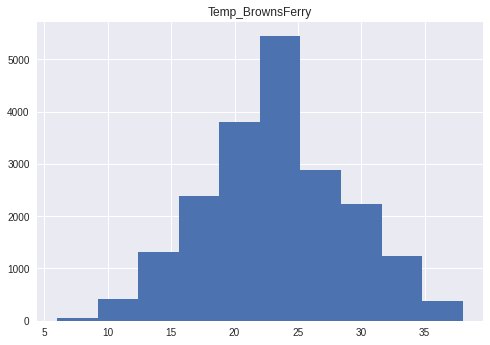

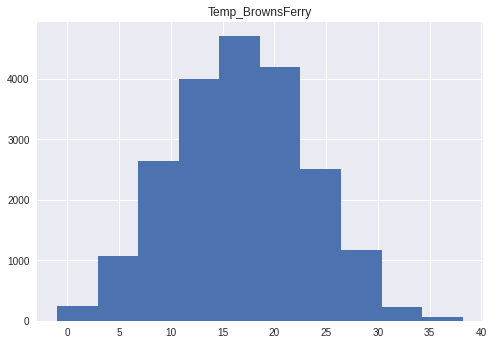

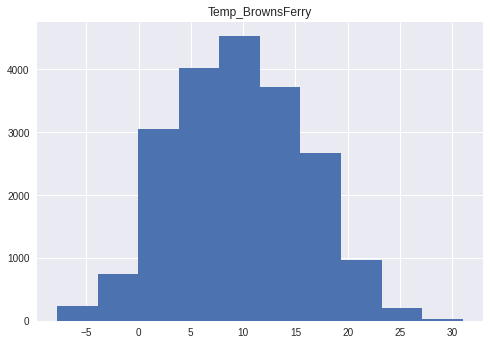

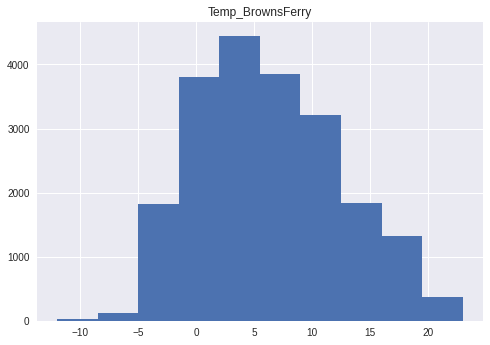

In [129]:
temp_df.groupby(temp_df.index.month).hist()